# PNN for particle detection in HEP

In ***High Energy Physics*** it is common that one has to decide if the data that is taken is from some specific signal ($H_{a}$) or from the background ($H_{0}$).<br>
This is simple binary hypothesis testing. For big experiments and complicated processes the likelihood may not be known and therefore has to be learned. <br>
Neural Network provide a very nice approach to this problem. In this case, a NN is trained on parameterized (means as hypothesis) 1-dimesional data.

In [256]:
# standard python libraries for data maniipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

## 0) Signal and background event visualization

Gaussian distributions of which one is the background and the other is the signal.

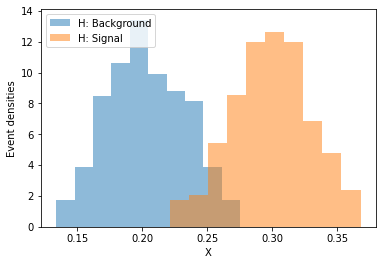

In [257]:
#np.random.seed(42)
sizes = 200
background = np.random.normal(loc=0.200, scale=0.03, size=sizes)
signal = np.random.normal(loc=0.300, scale=0.03, size=sizes)
plt.hist(background, bins=10, label=f"H: Background", density=True, alpha=0.5)
plt.hist(signal, bins=10, label=f"H: Signal", density=True, alpha=0.5)
plt.legend()
plt.xlabel("X")
plt.ylabel("Event densities")
plt.show()

## 1) Create custom dataset for training the PNN

In [258]:
# torch library for machine learning and utilities for data generating process
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

In [259]:
class CustomDataset(Dataset):
    def __init__(self, x_range_lower: float = 0.0,
                        x_range_upper: float = 1.0,
                        trained_params: int = 10,
                       data_points: int = 1000,
                       total_generations: int = 10000):
        """Generates data for NN training. Output is the parameterized data
        X and the labels Y per dataset index. 

        Args:
            x_range_lower (float, optional): Lower border of data training. Defaults to 0.0.
            x_range_upper (float, optional): Upper border of data training. Defaults to 1.0.
            trained_params (int, optional): Devides range from lower to upper bound into equal segments to 
            improve scaling performance on the training range. Defaults to 10.
            data_points (int, optional): Amount of data points generated per each event. Defaults to 1000.
            total_generations (int, optional): Amount of events that the NN is trained on. Defaults to 10000.
        """
        # seeding for ensuring to always generate the same data
        np.random.seed(42)
        
        # default class variables
        self.x_range_lower = x_range_lower
        self.x_range_upper = x_range_upper
        self.trained_params = trained_params
        self.data_points = data_points
        self.total_generations = total_generations

        # hypothesis
        hypothesis = np.linspace(start=self.x_range_lower,
                                 stop=self.x_range_upper,
                                 num=self.trained_params)


        # empty dataset holding the generations of events
        self.dataset = {}

        # iterating over amount of generations and storing
        # converted tensors in dataset
        for gen_idx in range(self.total_generations):

            # empty vector that holds the data from the events from one generation (x, H_bg, H_signal)
            X = np.zeros(shape=(self.data_points * 2, 3))

            # random selection of hypothesis
        
            background, signal = np.random.choice(hypothesis,2)

            # vector that contains the targets for binary classification (0,...,0,1,...,1)
            Y = np.concatenate([np.zeros(self.data_points), np.ones(self.data_points)])

            # event generation for hypothesis
            X[:self.data_points, 0] = np.random.normal(loc = background, scale = 0.02, size = self.data_points)
            X[self.data_points:, 0] = np.random.normal(loc = signal, scale = 0.02, size = self.data_points)

            # hypothesis for parameterizing the NN
            X[:, 1] = np.ones(self.data_points * 2) * background
            X[:, 2] = np.ones(self.data_points * 2) * signal


            # make tensors
            X = torch.tensor(X, requires_grad=True).float()
            Y = torch.tensor(Y, requires_grad=True).float()

            self.dataset[gen_idx] = (X, Y)

    def __len__(self):
        return self.total_generations # len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]

Generate the data.

In [260]:
custom_ds = CustomDataset()
custom_dl = DataLoader(custom_ds, batch_size=16, shuffle=True)

Example of dataset event.

In [261]:
# custom_ds[0]

## 2) Construct Neural Network with hypothesis as extra input features

In [262]:
# torch functionalities for NN designing
import torch.nn as nn
import torch.nn.functional as F

In [263]:
class ParameterizedNeuralNet(pl.LightningModule):
    def __init__(self): 
        """Neural Network parameterized with hypothesis of signal and background
        means.
        """
        super().__init__()

        # losses for training process visualization
        self.losses = []

        # network structure
        self.net = nn.Sequential(nn.Linear(in_features=3, out_features=40),
                                 nn.PReLU(),
                                 nn.Linear(in_features=40, out_features=60),
                                 nn.PReLU(),
                                 nn.Linear(in_features=60, out_features=40),
                                 nn.PReLU(),
                                 nn.Linear(in_features=40, out_features=20),
                                 nn.PReLU(),
                                 nn.Linear(in_features=20, out_features=1),
                                 nn.Sigmoid())
                                 
    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optim  = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optim

    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch
        Y_hat = self.net(X)
        loss = F.binary_cross_entropy(torch.squeeze(Y_hat, -1), Y)
        self.losses.append(loss.detach().numpy())
        self.log("train_loss", loss)
        return loss

## 3) Train the NN

In [264]:
# initalilizing the model
model = ParameterizedNeuralNet()

# initializing the trainer
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=10)

# train the model on the dataset
trainer.fit(model, custom_dl)

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 5.9 K 
------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: 

Training: 0it [00:00, ?it/s]

## 4) Loss of the training

Visualization of training process.

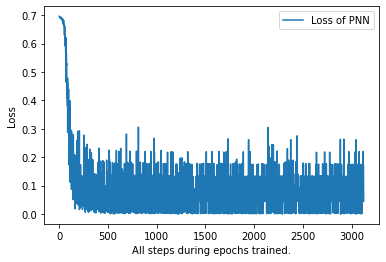

In [265]:
losses = np.asarray(model.losses)
losses.shape

plt.plot(np.arange(0,losses.shape[0]), losses, label="Loss of PNN")
plt.xlabel("All steps during epochs trained.")
plt.ylabel("Loss")
plt.legend()

## 5) Test some examples of PNN

Visualization of different signals plotted against one background.

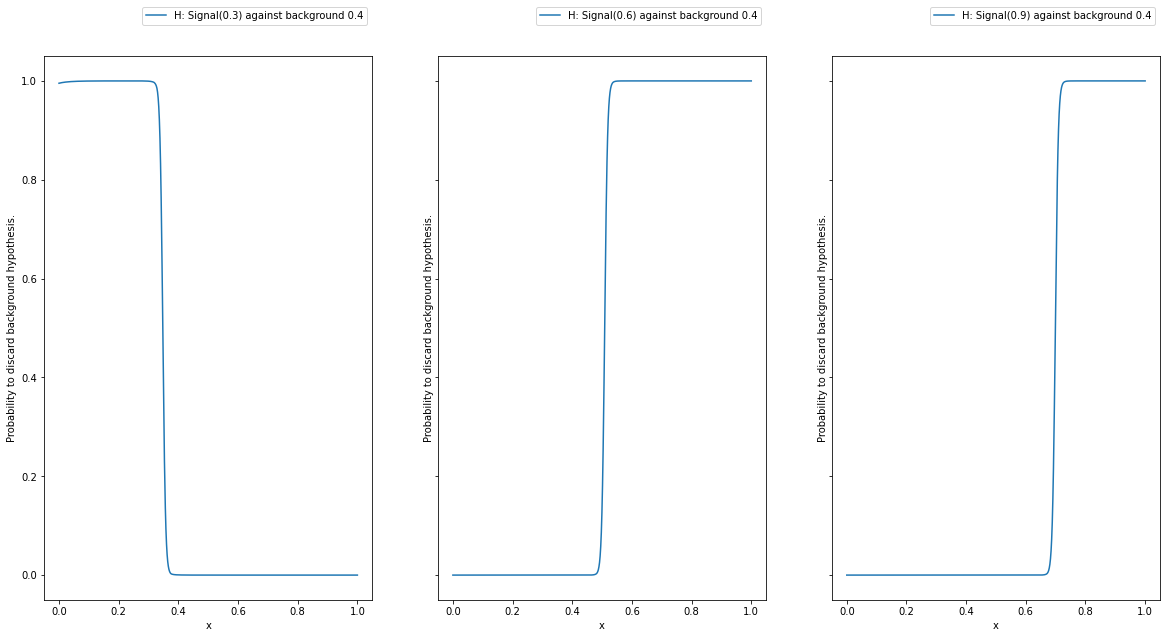

In [268]:
# trained range
x_range = np.linspace(0.00, 1.00, 1000)

# background and signals
bg = 0.400
signals = [0.300, 0.600, 0.900]

# different subplots for the results
fig, axes = plt.subplots(ncols=len(signals), sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)

# iterating through the binary classification processes

for signal_idx, signal in enumerate(signals):

    # generating background and hypothesis
    hypothesis = np.ones_like(x_range) * signal
    background = np.ones_like(x_range) * bg

    # creation data vector for the PNN
    data = np.empty((1000, 3))
    data[:, 0] = x_range
    data[:, 1] = background
    data[:, 2] = hypothesis

    # pushing to tensor format
    data_tensor = torch.tensor(data).float()

    # model evaluation
    res = model(data_tensor).detach().numpy()


    axes[signal_idx].plot(x_range, res, label=f"H: Signal({signal}) against background {bg}")
    axes[signal_idx].set_ylabel("Probability to discard background hypothesis.")
    axes[signal_idx].legend(bbox_to_anchor=(1, 1.1))
    axes[signal_idx].set_xlabel("x")


plt.show()

## 6) ROC and AUC